# Task 1

### 1) Create a 2-variate AR(2) time series

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import f

In [2]:
# INPUT PARAMETERS
# total time steps
T = 1000

# set random seed
np.random.seed(19062019)

# define empty ts matrix
data = np.zeros((2,T))

# setting initial conditions
data[:,0] = [0., 0.]

# model parameters (a0 = [0,0])
A1 = np.array(( [0.2, -0.2], [0., 0.1] ))
A2 = np.array(( [0.1, -0.1], [0., 0.1] ))

A_model = np.concatenate( ([0.0,0.0], A1, A2), axis=None)

# noise covariance matrix
cov = np.array(( [0.01, 0], [0, 0.01] ))

In [3]:
# CREATE THE TIME SERIES
# generate values from the gaussian noise
epsilon = np.random.multivariate_normal([0.,0.], cov, T).T

# loop over time steps
data[:, 1] = np.dot(A1, data[:,0]) + epsilon[:,0]

for i in range(2,T):
    data[:, i] = np.dot(A1, data[:,i-1]) + np.dot(A2, data[:,i-2]) + epsilon[:,i-1]

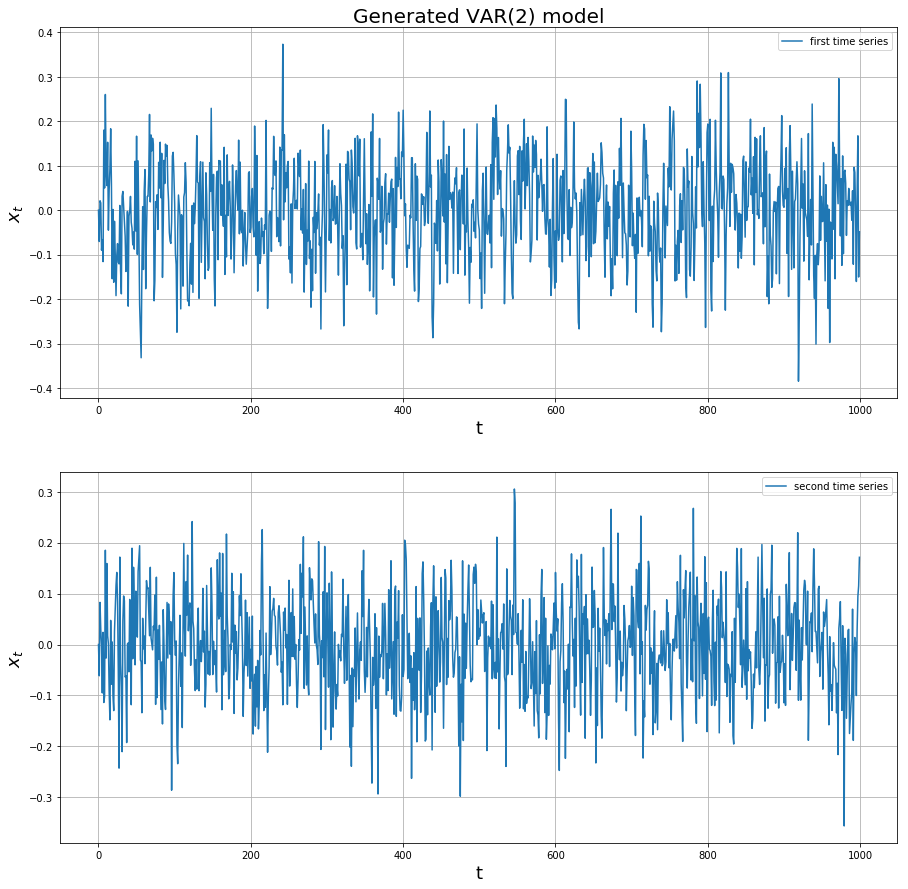

In [4]:
# PLOT GENERATED TIME SERIES
fig1 = plt.subplots(figsize=[15,15])

plt.subplot(2,1,1)
plt.plot(np.arange(T), data[0,:], label='first time series')
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$x_t$', fontsize = 18)
plt.grid()
plt.legend()
plt.title('Generated VAR(2) model', fontsize = 20)

plt.subplot(2,1,2)
plt.plot(np.arange(T), data[1,:], label='second time series')
plt.xlabel('t', fontsize = 18)
plt.ylabel(r'$x_t$', fontsize = 18)
plt.grid()
plt.legend()

plt.show(fig1)

### 2) Given your knowledge of model parameters above, does x1 Granger-cause x2, or does x2 Granger-cause x1 according to Granger’s definition? Why?

As we can notice by looking at the matrix of the generating model, the lower-left (2,1) coefficients are both null: this means that the generated values of x2 don't depend on the previous value of x1 and for this reason we can deduce that x1 does not Granger-cause x2. On the other hand the upper-left (1,2) are different from zero, so we can deduce that x2 does Granger-cause x1.

### 3) Assuming that the order of the model (p = 2) is known, use the log-likelihood-ratio test statistic to confirm your results from (2)

In [5]:
# USEFUL FUNCTIONS
# Coefficient estimation for AR(p) model
def coeff_AR(data, p):
    xT = data[p:]
    Xp = np.zeros((len(data)-p,p+1))
    
    # add 1 as first element
    Xp[:,0] = 1
    
    # fill matrix Xp with data
    for i in range(1,p+1):
        Xp[:,i] = data[p-i:-i]
    
    # compute coefficients
    temp = np.matmul(np.transpose(Xp),Xp)
    temp = np.linalg.inv(temp)
    a = np.matmul(np.transpose(Xp),xT)
    a = np.matmul(temp,a)
    
    return a

# define p as a global variable
p = 2

# coefficient estimation for VAR(p)
def coeff_VAR(data, p):
    data = data.T
    T = data.shape[0]
    n = data.shape[1]
    
    # define empty matrix
    A = np.zeros(( n, n*p+1 ))
    xT = np.zeros(T-p)
    Xp = np.zeros(( (T-p), n*p+1 ))
    
    # add column of 1s
    Xp[:,0] = np.zeros(T-p) + 1
    
    # fill matrix Xp with data
    for i in range(n):        
        for k in range(1,p+1):
            Xp[ :, i*p +k ] = data[p-k:-k, i]
        
    # compute coefficients
    for i in range(n):
        xT = data[p:, i]
        
        temp = np.matmul(np.transpose(Xp),Xp)
        temp = np.linalg.inv(temp)
        a = np.matmul(np.transpose(Xp),xT)
        a = np.matmul(temp,a)
        A[i] = a
    
    return A

# inferred VAR time series, given coefficient matrices
def pred_VAR(data, a0, A1, A2):
    T = data.shape[1]
    n = data.shape[0]
            
    # define empty array
    x_new = np.zeros((n,T))
    # set first p values
    x_new[:,:p] = data[:,:p]
    
    for i in range(p,T):
        x_new[:, i] = a0 + np.dot(A1, data[:,i-1]) + np.dot(A2, data[:,i-2])
    
    return x_new

# Residuals of the VAR(p) model
def res(data, a0, A1, A2):
    return pred_VAR(data, a0, A1, A2)[:,p:] - data[:,p:]

# Covariance matrix of the residuals
def sigma(data, a0, A1, A2):
    return np.cov(res(data, a0, A1, A2))

# Log-likelihood for VAR(p) model
def log_likelihood(data, a0, A1, A2):
    T = data.shape[1]
    n = data.shape[0]
        
    res1 = res(data, a0, A1, A2)
    sigma1 = sigma(data, a0, A1, A2)
    det = np.linalg.det(sigma1)
    
    t1 = - 0.5 * (T-p)*n * np.log(2*np.pi)
    t2 = - 0.5 * (T-p) * np.log(det)
    t3 = 0.
    for i in range(T-p):
        temp = np.dot(np.linalg.inv(sigma1), res1[:,i])
        t3 += np.dot(res1[:,i], temp)
    t3 = - 0.5 * t3
    
    return t1 + t2 + t3

In [6]:
# NULL HYPOTHESIS: no Granger Causalities 
# diagonal A1 and A2 matrices / two sigle AR model
a1 = coeff_AR(data[0,:], p=2)
a2 = coeff_AR(data[1,:], p=2)

A0_null = np.array(([a1[0],a2[0]]))
A1_null = np.array(([a1[1], 0.0], [0.0, a2[1]]))
A2_null = np.array(([a1[2], 0.0], [0.0, a2[2]]))

A_null = np.concatenate( (A0_null,A1_null,A2_null), axis=None)

print('Null hypothesis parameters')
print('A0:\n', A0_null)
print('A1:\n', A1_null)
print('A2:\n', A2_null)

Null hypothesis parameters
A0:
 [ 9.90742761e-05 -1.68220466e-03]
A1:
 [[0.24370888 0.        ]
 [0.         0.13194647]]
A2:
 [[0.09095963 0.        ]
 [0.         0.10616485]]


In [7]:
# COMPLETE HYPOTHESIS: VAR(2) model
A = coeff_VAR(data, p=2)

A0_var = A[:,0]
A1_var = np.array((A[:,1], A[:,3])).T
A2_var = np.array((A[:,2], A[:,4])).T

A_var = np.concatenate( (A0_var,A1_var,A2_var), axis=None)

print('Complete model parameters')
print('A0:\n', A0_var)
print('A1:\n', A1_var)
print('A2:\n', A2_var)

Complete model parameters
A0:
 [-0.00066633 -0.00167826]
A1:
 [[ 0.22035789 -0.17975054]
 [ 0.00785193  0.13189426]]
A2:
 [[ 0.09273513 -0.11843226]
 [-0.00411085  0.10766649]]


In [8]:
# FIRST ALTERNATIVE HYPOTHESIS: x1 doesn't Granger causes x2
A0_x2 = np.array((A[0,0], a2[0]))
A1_x2 = np.array((A1_var))
A1_x2[1] = np.array(([0.0, a2[1]]))
A2_x2 = np.array((A2_var))
A2_x2[1] = np.array(([0.0, a2[2]]))

A_x2 = np.concatenate( (A0_x2,A1_x2,A2_x2), axis=None)

print('(x1 not G.C. x2) model parameters')
print('A0:\n', A0_x2)
print('A1:\n', A1_x2)
print('A2:\n', A2_x2)

(x1 not G.C. x2) model parameters
A0:
 [-0.00066633 -0.0016822 ]
A1:
 [[ 0.22035789 -0.17975054]
 [ 0.          0.13194647]]
A2:
 [[ 0.09273513 -0.11843226]
 [ 0.          0.10616485]]


In [9]:
# SECOND ALTERNATIVE HYPOTHESIS: x2 doesn't Granger causes x1
A0_x1 = np.array((A[0,0], a2[0]))
A1_x1 = np.array((A1_var))
A1_x1[0] = np.array(([a1[1], 0.0]))
A2_x1 = np.array((A2_var))
A2_x1[0] = np.array(([a1[2], 0.0]))

A_x1 = np.concatenate( (A0_x1,A1_x1,A2_x1), axis=None)

print('(x2 not G.C. x1) model parameters')
print('A0:\n', A0_x1)
print('A1:\n', A1_x1)
print('A2:\n', A2_x1)

(x2 not G.C. x1) model parameters
A0:
 [-0.00066633 -0.0016822 ]
A1:
 [[0.24370888 0.        ]
 [0.00785193 0.13189426]]
A2:
 [[ 0.09095963  0.        ]
 [-0.00411085  0.10766649]]


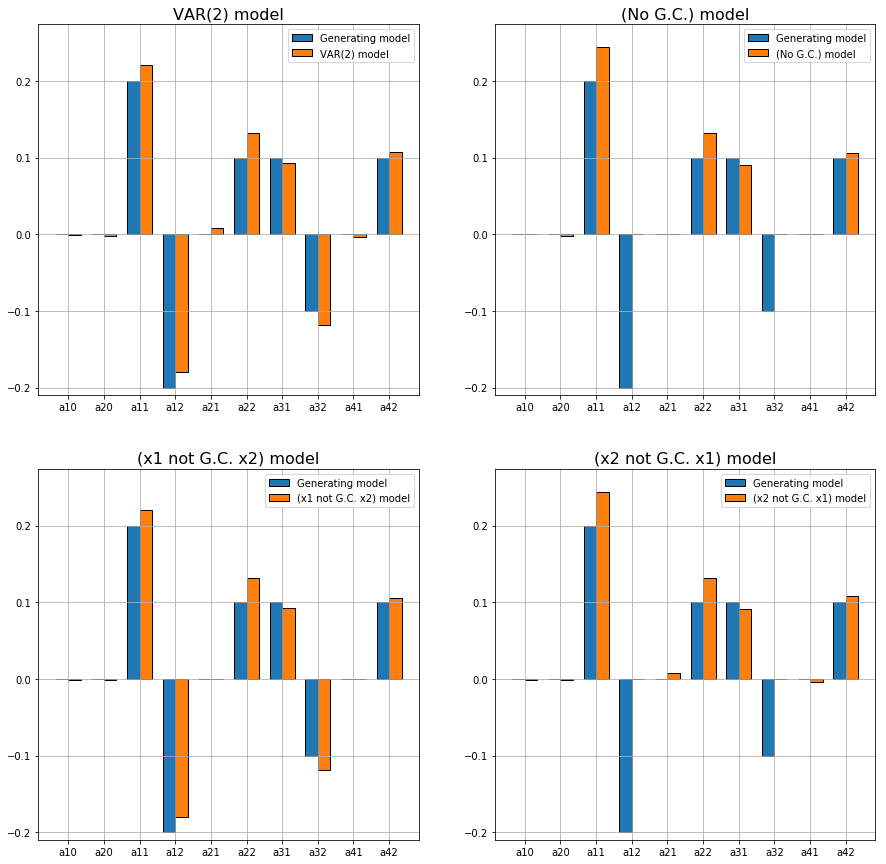

In [10]:
# PLOTS OF THE COEFFICIENTS FOR DIFFERENT MODELS
A = np.array(([A_var, A_null, A_x2, A_x1]))

fig1 = plt.subplots(figsize=[15,15])
width = 0.35
xs = np.arange(A.shape[1])

x_ticks = ['a10','a20','a11','a12','a21','a22', 'a31', 'a32', 'a41', 'a42']
titles = ['VAR(2) model', '(No G.C.) model', '(x1 not G.C. x2) model', '(x2 not G.C. x1) model']

for i in range(len(A)):
    plt.subplot(2,2,i+1)
    
    plt.bar(xs - width/2, A_model[:], width, label='Generating model', edgecolor = 'black')
    plt.bar(xs + width/2, A[i,:], width, label=titles[i], edgecolor = 'black')
    plt.xticks( xs, x_ticks )
    plt.ylim( [A.min()-0.03, A.max()+0.03] )
    plt.grid()
    plt.legend()
    plt.title(titles[i], fontsize = 16)

plt.show(fig1)

In [11]:
# LOG-LIKELIHOOD COMPUTATION FOR DIFFERENT MODELS
k = 2

ll = log_likelihood(data, A0_var, A1_var, A2_var)
print('log-likelihood for complete model:, ', ll)

llnull = log_likelihood(data, A0_null, A1_null, A2_null)
print('log-likelihood for restricted model: ', llnull)

llx1 = log_likelihood(data, A0_x1, A1_x1, A2_x1)
print('log-likelihood for (x2 not G.C. x1) model: ', llx1)

llx2 = log_likelihood(data, A0_x2, A1_x2, A2_x2)
print('log-likelihood for (x1 not G.C. x2) model: ', llx2)

log-likelihood for complete model:,  1786.56817554403
log-likelihood for restricted model:  1764.08138802638
log-likelihood for (x2 not G.C. x1) model:  1764.096829255153
log-likelihood for (x1 not G.C. x2) model:  1786.528964484111


In [12]:
# LLR-TEST - respect to the Complete VAR model
from scipy.stats import f

D1 = -2. * (llx1 - ll)
D2 = -2. * (llx2 - ll)

print('D for (x2 not G.C. x1) model:', D1)
print('cdf(D) for (x2 not G.C. x1) model:', chi2.cdf(D1, k) )
print()
print('D for (x1 not G.C. x2) model:', D2)
print('cdf(D) for (x1 not G.C. x2) model:', chi2.cdf(D2, k) )

D for (x2 not G.C. x1) model: 44.942692577754315
cdf(D) for (x2 not G.C. x1) model: 0.9999999998258922

D for (x1 not G.C. x2) model: 0.07842211983825109
cdf(D) for (x1 not G.C. x2) model: 0.03845225646081886


In [13]:
# F-TEST - respect to the Complete VAR model
from scipy.stats import f

sigma_var = sigma(data, A0_var, A1_var, A2_var)
sigma_x1 = sigma(data,A0_x1, A1_x1, A2_x1)
sigma_x2 = sigma(data,A0_x2, A1_x2, A2_x2)

Fx1 = (T-p-1) / k * ( np.log(np.linalg.det(sigma_x1)) - np.log(np.linalg.det(sigma_var)) )
Fx2 = (T-p-1) / k * ( np.log(np.linalg.det(sigma_x2)) - np.log(np.linalg.det(sigma_var)) )

print('F for (x2 not G.C. x1) model:', Fx1)
print('cdf(F) for (x2 not G.C. x1) model:', f.cdf(Fx1, k, (T-p-1)-k*(p+1)-1 ) )
print()
print('F for (x1 not G.C. x2) model:', Fx2)
print('cdf(F) for (x1 not G.C. x2) model:', f.cdf(Fx2, k, (T-p-1)-k*(p+1)-1 ) )

F for (x2 not G.C. x1) model: 22.42235108827798
cdf(F) for (x2 not G.C. x1) model: 0.9999999997006309

F for (x1 not G.C. x2) model: 0.03917177028048702
cdf(F) for (x1 not G.C. x2) model: 0.03841298654551087


In [14]:
# LLR-TEST - respect to the Complete VAR model
D1 = -2. * (llnull - llx1)
D2 = -2. * (llnull - llx2)

print('D for (x2 not G.C. x1) model:', D1)
print('cdf(D) for (x2 not G.C. x1) model:', chi2.cdf(D1, k) )
print()
print('D for (x1 not G.C. x2) model:', D2)
print('cdf(D) for (x1 not G.C. x2) model: ', chi2.cdf(D2, k) )

D for (x2 not G.C. x1) model: 0.0308824575458857
cdf(D) for (x2 not G.C. x1) model: 0.015322624251171488

D for (x1 not G.C. x2) model: 44.89515291546195
cdf(D) for (x1 not G.C. x2) model:  0.9999999998217041


In [15]:
# F-TEST - respect to the 2-AR model
sigma_null = sigma(data, A0_null, A1_null, A2_null)

Fx1 = (T-p-1) / k * ( np.log(np.linalg.det(sigma_null)) - np.log(np.linalg.det(sigma_x1)) )
Fx2 = (T-p-1) / k * ( np.log(np.linalg.det(sigma_null)) - np.log(np.linalg.det(sigma_x2)) )

print('F for (x2 not G.C. x1) model:', Fx1)
print('cdf(F) for (x2 not G.C. x1) model:', f.cdf(Fx1, k, (T-p-1)-k*(p+1)-1 ) )
print()
print('F for (x1 not G.C. x2) model:', Fx2)
print('cdf(F) for (x1 not G.C. x2) model:', f.cdf(Fx2, k, (T-p-1)-k*(p+1)-1 ) )

F for (x2 not G.C. x1) model: 0.04190457815246251
cdf(F) for (x2 not G.C. x1) model: 0.0410370170910969

F for (x1 not G.C. x2) model: 22.425083896149957
cdf(F) for (x1 not G.C. x2) model: 0.9999999997014126


By looking at the value of the F test respect to the estimated VAR(2) model, we can reject the assumption that x2 Granger-cause x1 at 1% significance level, while we can accept the assumption that x1 Granger-cause x2 at 1% significance level.

# Task 2

### Consider a linear Gaussian state space model:
$$ z_t = Az_{t-1} + \epsilon, \ \epsilon \sim N(0,\Sigma) $$
$$ x_t = Bz_{t} + \epsilon, \ \eta \sim N(0,\Gamma) $$
### Derive the M-step for the latent state noise Σ and the observation matrix B by maximizing the expected log-likelihood E[logp(X,Z)], with respect to Σ and B, where X={xt |t∈1...T} and Z={zt |t∈1...T} are the sets of all latent states and observations from time 1 to T 